NOTEBOOK IS A WORKBOOK, for reference only

In [ ]:
%reload_ext autoreload 
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

In [ ]:
import jax
import jax.numpy as jnp
import hamux as hmx
import treex as tx
from flax import linen as nn # For initializers
import optax
import jax.tree_util as jtu
from typing import *
import matplotlib.pyplot as plt
from dataclasses import dataclass
from loguru import logger
from einops import rearrange
from tqdm.auto import trange, tqdm
from pathlib import Path
from torch.utils.data import DataLoader
import numpy as np
import functools as ft

import matplotlib.colors as colors
plt.set_cmap('bwr') # a good start: blue to white to red colormap
norm = colors.TwoSlopeNorm(vcenter=0)

<Figure size 800x800 with 0 Axes>

In [ ]:
jax.devices()

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]

In [ ]:
def summarize_mnist_weights(ham, kh=32, kw=32, fig=None):
    # W2 = np.random.normal(size=(10,1024))
    norm = colors.TwoSlopeNorm(vcenter=0)

    Wimg = ham.synapses[0].W1
    Wlabel = ham.synapses[0].W2
    
    nWimg = jnp.sqrt(jnp.power(Wimg,2).sum(-2, keepdims=True))
    nWlabel = jnp.sqrt(jnp.power(Wlabel,2).sum(-2, keepdims=True))
    
    Wimg = Wimg / nWimg
    Wlabel = Wlabel / nWlabel
    
    # imgs_big = rearrange(np.repeat(imgs, 11, axis=0)[:1024], "... h w -> ... (h w)")[:,0].T
    Wimg_show = rearrange(Wimg, "(h w) (kh kw) -> (kh h) (kw w)", h=28, w=28, kh=kh, kw=kw)
    
    if fig is None:
        fig, axs = plt.subplots(1, 2, figsize=(12,6), width_ratios=(2,5))
    else:
        axs = fig.subplots(1, 2, width_ratios=(2,5))
    def prep_axis(ax):
        ax.axis('off')
    [prep_axis(ax) for ax in axs]

    pos0 = axs[0].imshow(Wlabel.T[:20], aspect="auto", interpolation="nearest")
    # fig.colorbar(pos0, ax=axs[0], location="right", shrink=0.7)
    axs[0].set_title("Label matrix")

    pos1 = axs[1].imshow(Wimg_show, norm=norm)
    axs[1].set_title("pixel_matrix")
    fig.colorbar(pos1, ax=axs[1], location="right", shrink=0.7)


#     axs[2].set_title("activations")
#     pos2 = axs[2].imshow(W2[:1].T, aspect="auto", interpolation="nearest")
#     fig.colorbar(pos2, ax=axs[2], location="right")
    return fig

<matplotlib.image.AxesImage>

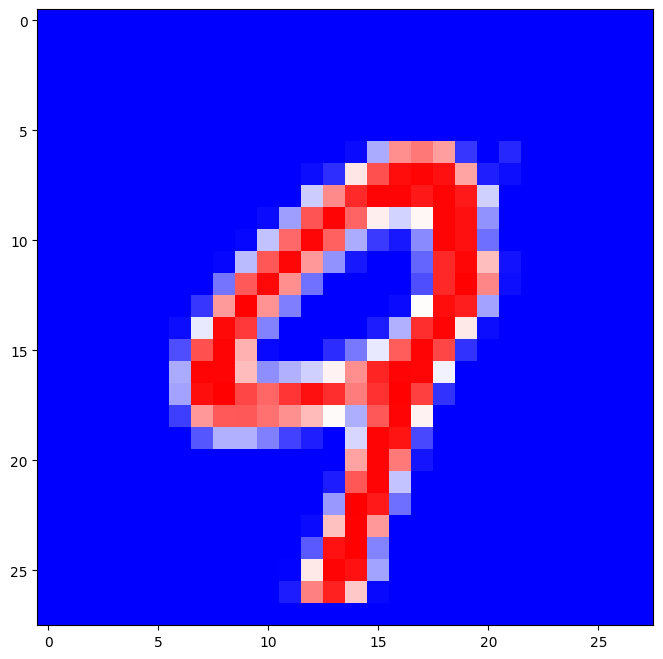

In [ ]:
from hamux.datasets import *

dl_args = DataloadingArgs(
    dataset="torch/MNIST",
    # aa="rand",
    aa=None,
    reprob=0.,
    vflip=0.0,
    hflip=0.0,
    scale=(0.9, 1.1),
    batch_size=100,
    color_jitter=0.0,
    validation_batch_size=1000,
)
data_config = DataConfigMNIST(input_size=(1, 28, 28), mean=0.5, std=0.5)

train_dl, eval_dl = create_dataloaders(dl_args, data_config)

for batch in train_dl:
    imgs, labels = batch
    break
    
plt.imshow(data_config.show(imgs[2]))

In [ ]:
def normal_init(std=1.0, mean=0.0):
    def _f(key, shape, dtype=jnp.float64):
        return (jax.random.normal(key, shape, dtype=dtype) * std) + mean
    return _f

class HopfieldNetworkAsSynapse(hmx.Synapse):
    """A simple reimplementation of a Hopfield Network as a synapse, returning the alignment"""
    W1: jnp.ndarray = tx.Parameter.node() # treex's preferred way of declaring an attribute as a parameter
    W2: jnp.ndarray = tx.Parameter.node()
    nhid: int
    beta: float = tx.Parameter.node()
    
    def __init__(self, nhid:int, beta_init=0.1):
        self.nhid = nhid
        self.beta = beta_init
    
    def __call__(self, g1, g2):
        """The alignment function, defined on an unbatched `g`"""
        if self.initializing():
            self.W1 = normal_init(mean=0.0, std=0.01)(tx.next_key(), g1.shape + (self.nhid,))
            self.W2 = normal_init(std=0.01)(tx.next_key(), g2.shape + (self.nhid,))
        # hidsig = g1 @ self.W1 + g2 @ self.W2
        # hidsig = - jnp.abs(self.W1 - g1[:,None]).sum(-2) - jnp.abs(self.W2 - g2[:,None]).sum(-2)
        # hidsig = - jnp.pow(jnp.abs(self.W1 - g1[:,None]),2).sum(-2) - jnp.pow(jnp.abs(self.W2 - g2[:,None]),2).sum(-2)

        # nW1 = jnp.abs(self.W1).sum(-2, keepdims=True)
        # nW2 = jnp.abs(self.W2).sum(-2, keepdims=True)
        nW1 = jnp.sqrt(jnp.power(self.W1,2).sum(-2, keepdims=True))
        nW2 = jnp.sqrt(jnp.power(self.W2,2).sum(-2, keepdims=True))
        
        hidsig = g1 @ (self.W1 / nW1) + g2 @ (self.W2 / nW2)

        # hid_lagrangian_value = 1/self.beta * jax.nn.logsumexp(self.beta * hidsig, axis=-1)
        hid_lagrangian_value = (1/self.beta * jnp.exp(self.beta * hidsig)).sum(-1)
        return hid_lagrangian_value
    
ImageLayer = hmx.Layer(hmx.lagrangians.LSphericalNorm(), (28*28,))
# ImageLayer = hmx.Layer(hmx.lagrangians.LTanh(beta=0.5), (28*28,))
LabelLayer = hmx.Layer(hmx.lagrangians.LSoftmax(beta=0.005), (10,))

layers = [ImageLayer, LabelLayer]
synapses = [HopfieldNetworkAsSynapse(nhid=32**2, beta_init=7.)]
connections = [((0,1),0)]
ham = hmx.HAM(layers, synapses, connections)

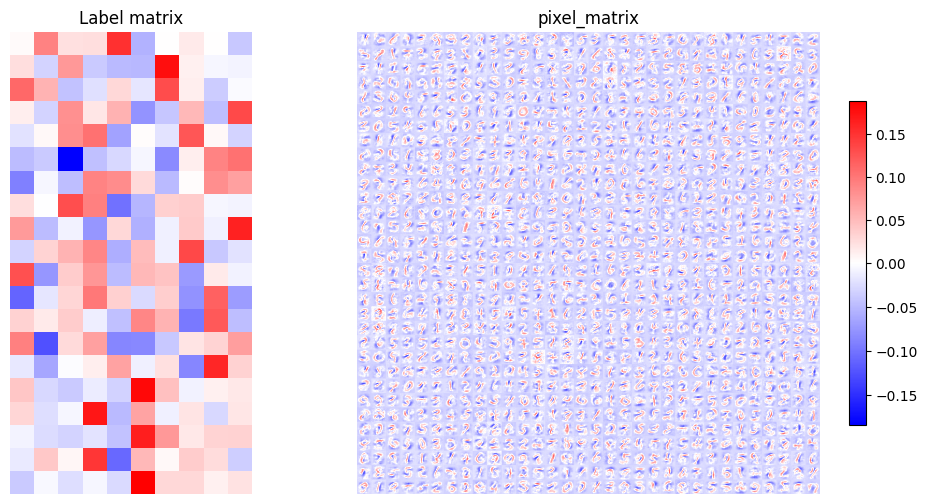

In [ ]:
model_fname = "_logs/DummyMNIST_epoch-67_acc-97.890.pckl"
loaded_model = hmx.HAM.load_ckpt(ham, model_fname)
summarize_mnist_weights(loaded_model);

In [ ]:
def fwd_energy(model, x, depth=4, dt=0.4, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(x.shape[0], rng=rng)
    xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our visible data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)
    
    # if clamp_label is not None:
    #     xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1.)
    #     print(xs[-1])
    #     masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

In [ ]:
img_start = batch[0][:1]
# img_start = jnp.ones_like(jnp.array(img_start))
energies, allxs = fwd_energy(loaded_model, img_start, dt=0.01, depth=60)

[<matplotlib.lines.Line2D>]

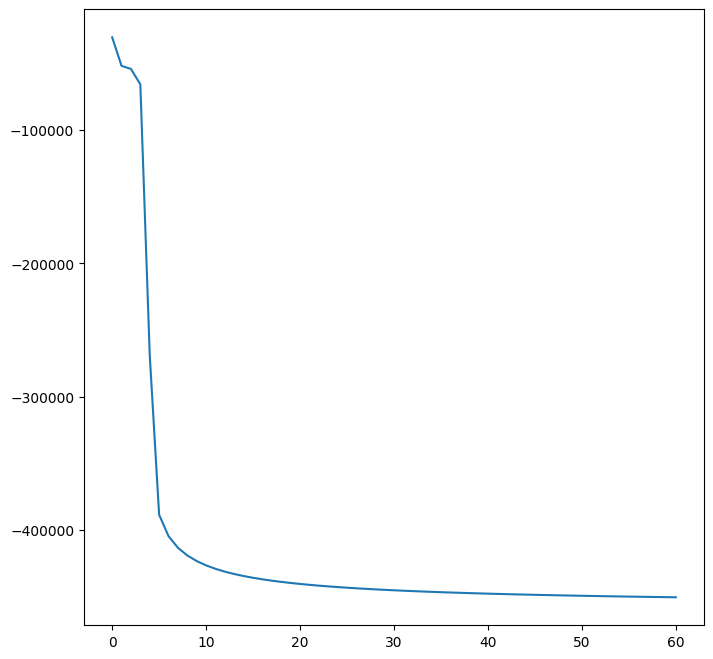

In [ ]:
plt.plot(energies)

<matplotlib.image.AxesImage>

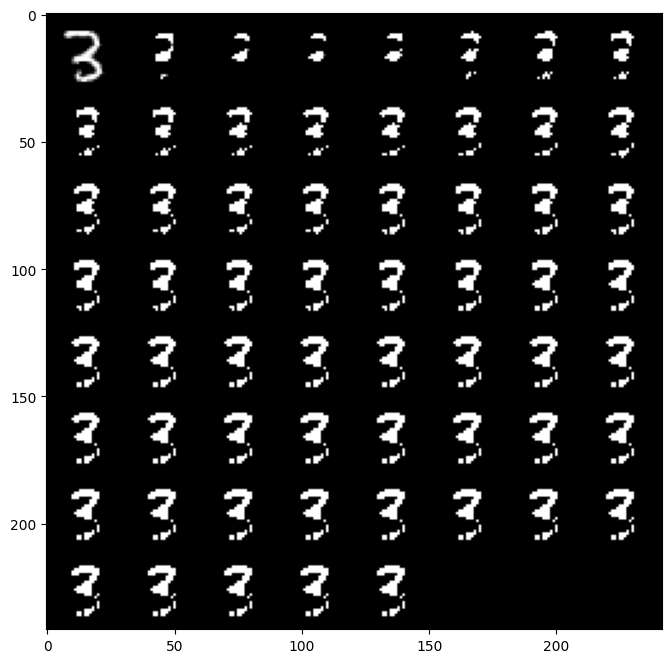

In [ ]:
from torchvision.utils import make_grid

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))

In [ ]:
def fwd_energy(model, clamp_label:int, depth=4, dt=0.4, rng=None):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    xs = model.init_states(1, rng=rng)
    # xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our label data over time
    masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)

    xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1050.)
    # xs[-1] = xs[-1].at[...,1].set(1000.)
    print(xs[-1])
    masks[-1] = jnp.zeros_like(masks[-1])

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images
    all_xs = [xs]
    energies = [model.venergy(xs)]

    for i in range(depth):
        updates = model.vupdates(xs)  # Calculate the updates
        xs = model.step(
            xs, updates, dt=dt, masks=masks
        )  # Add them to our current states
        all_xs.append(xs)
        energies.append(model.venergy(xs))

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return jnp.stack(energies), all_xs

Starting 0
Traced<ShapedArray(float32[1,10])>with<DynamicJaxprTrace(level=0/1)>


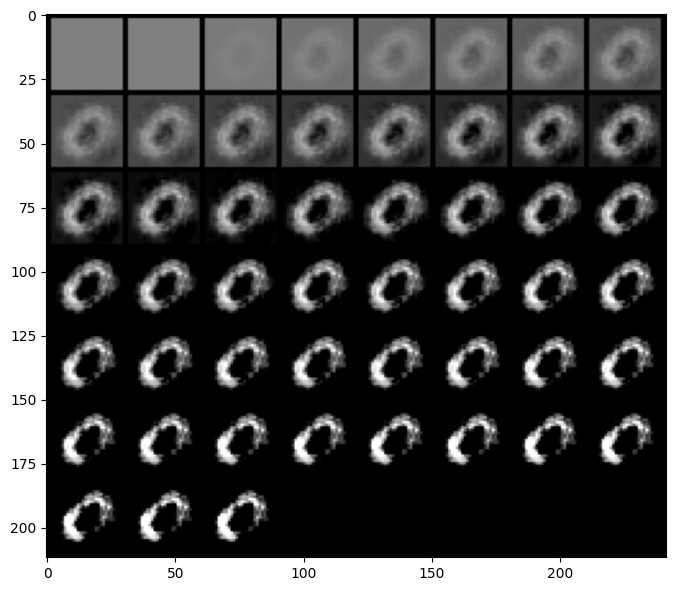

Starting 1


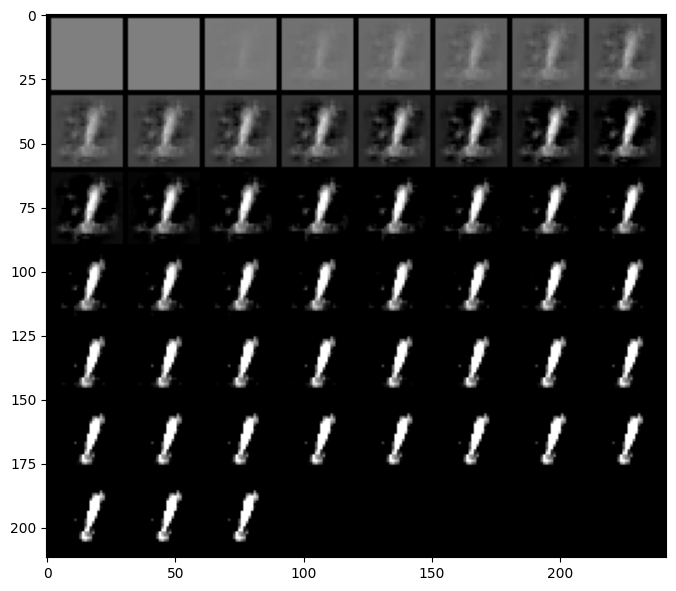

Starting 2


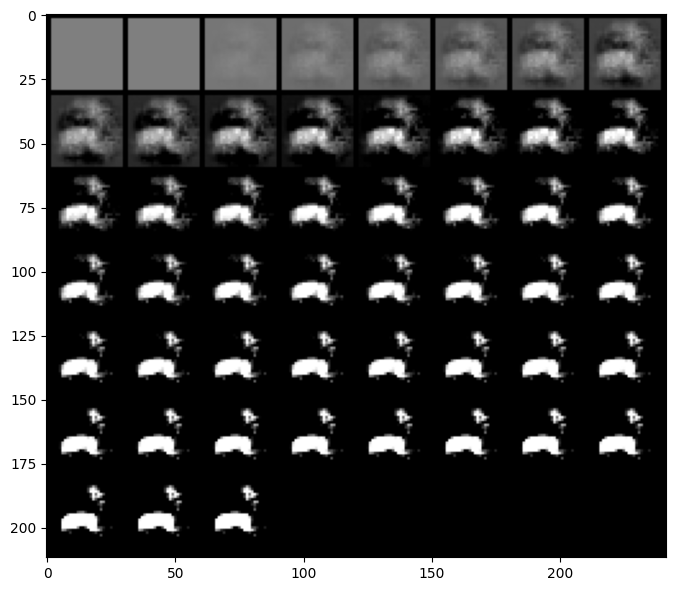

Starting 3


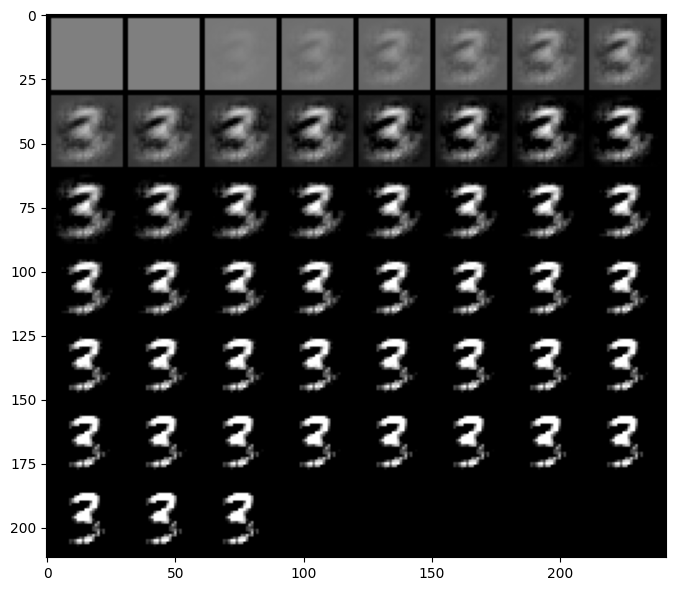

Starting 4


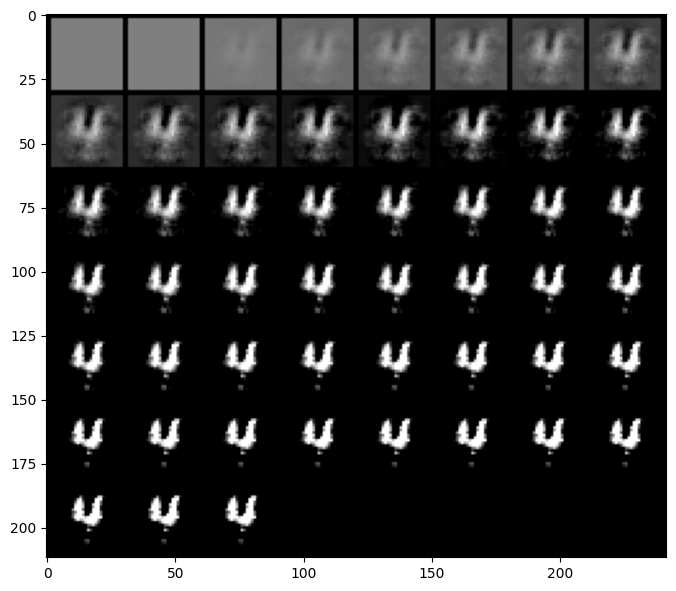

Starting 5


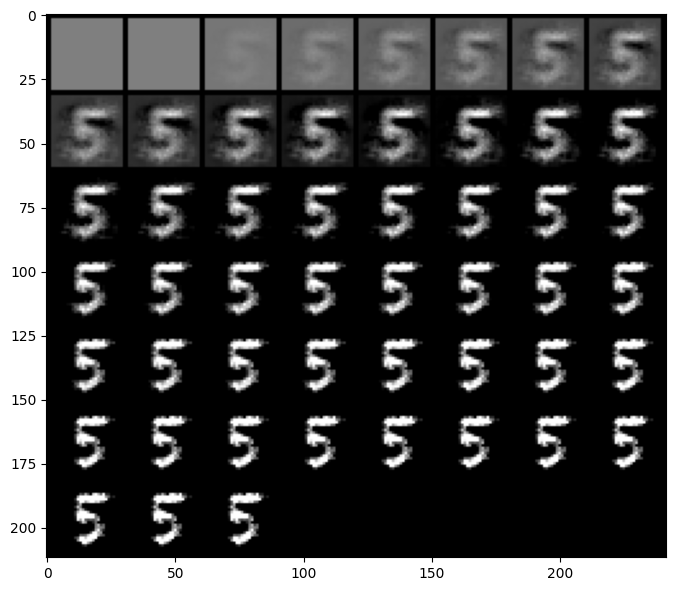

Starting 6


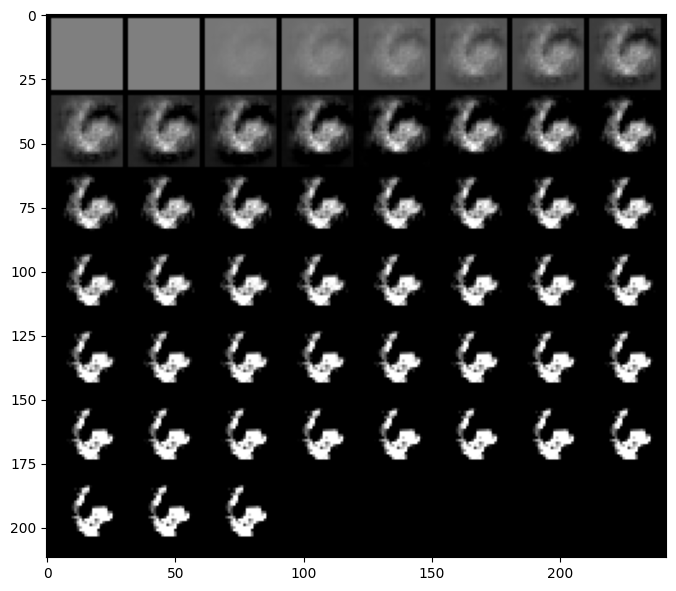

Starting 7


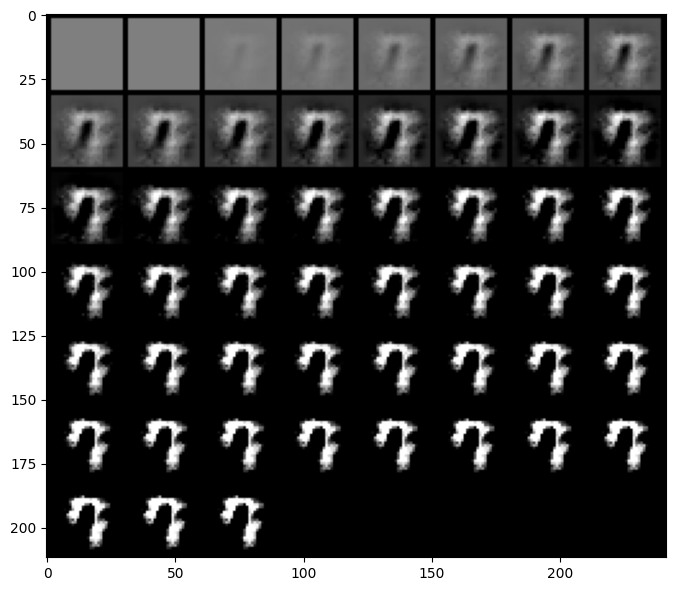

Starting 8


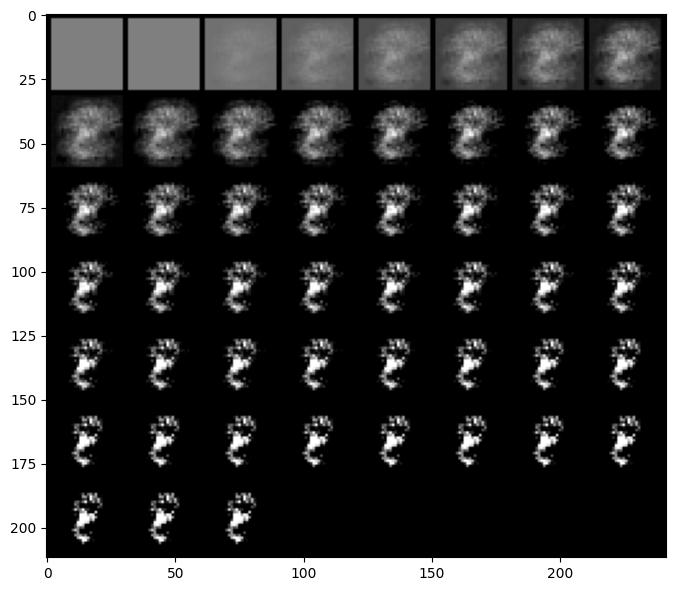

Starting 9


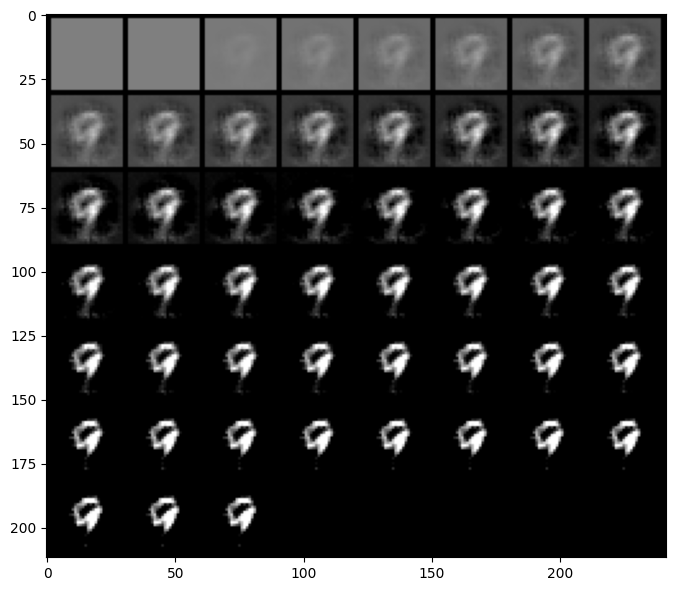

In [ ]:
from torchvision.utils import make_grid
img_start = batch[0][:1]

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

# aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

quick_fwd = jax.jit(fwd_energy, static_argnames=("depth"))

# plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))
for i in range(10):
    print(f"Starting {i}")
    energies, allxs = quick_fwd(loaded_model, clamp_label=i, dt=1e-6, depth=50)
    aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])
    plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))
    plt.show()

In [ ]:
linit = jnp.zeros((10,)).at[1].set(1000.).at[0].set(1000.)
loaded_model.layers[-1].g(linit)

Array([0.48687777, 0.48687777, 0.00328056, 0.00328056, 0.00328056,
       0.00328056, 0.00328056, 0.00328056, 0.00328056, 0.00328056],      dtype=float32)

[<matplotlib.lines.Line2D>]

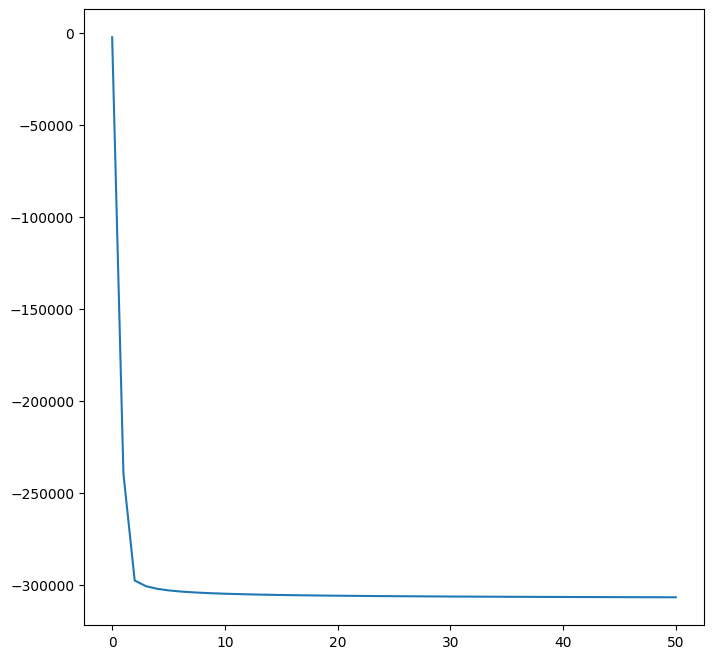

In [ ]:
plt.plot(energies)

<matplotlib.image.AxesImage>

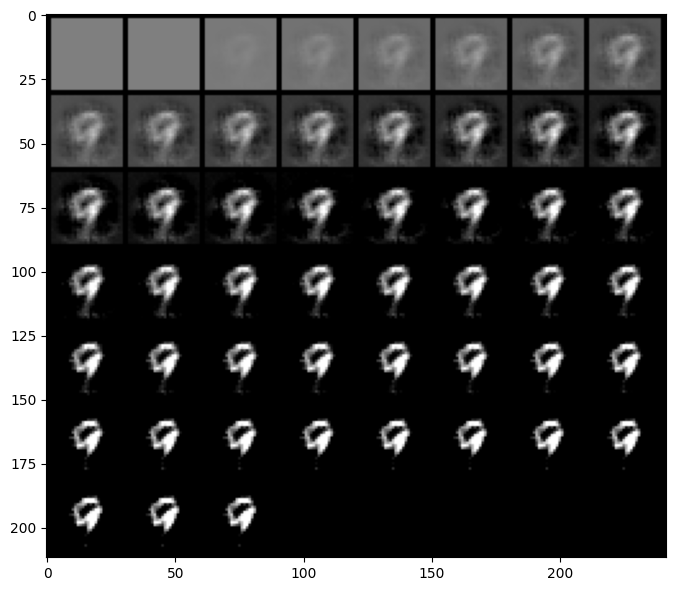

In [ ]:
from torchvision.utils import make_grid

def show_x(x):
    x = rearrange(x, "... (c h w) -> ... c h w", c=1, h=28, w=28)
    return data_config.show(torch.tensor(np.array(x)))

aa = make_grid([rearrange(torch.tensor(show_x(x[0][0])), "h w c -> c h w") for x in allxs])

plt.imshow(np.array(rearrange(aa, "c h w -> h w c")))

## TFJS

In [ ]:
import tensorflowjs as tfjs
import tensorflow as tf

2022-12-13 18:05:34.845537: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-13 18:05:35.480688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-13 18:05:35.480774: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-13 18:05:35.480782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## HAMUX to TFJS

tfjs converters work by default assuming a `flax`-like API:

```
fn(params, ...) -> output
```

However, treex does not assume a `params` input. How can we port the converter to use treex?

In [ ]:
model_fname = "_logs/DummyMNIST_epoch-67_acc-97.890.pckl"
loaded_model = hmx.HAM.load_ckpt(ham, model_fname)
# summarize_mnist_weights(loaded_model);

In [ ]:
from hamux.tfjs_helpers import convert_jax

In [ ]:
# # from jax.experimental.jax2tf.examples import jax2tfjs
# import tensorflowjs as tfjs
# import tensorflow as tf
# import tempfile
# from tensorflowjs.converters import tf_saved_model_conversion_v2 as saved_model_conversion
# from jax.experimental import jax2tf

# DType = Any
# PolyShape = jax2tf.shape_poly.PolyShape
# Array = Any
# _TF_SERVING_KEY = tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY

In [ ]:
# def fwd_energy_1step(model, img_pixels, labels, dt=0.4):
# def fwd_energy_1step(model, info):
def fwd_energy_1step(model, states, dt):
# def fwd_energy_1step(model, dt, states):
    """A pure function to extract desired information from the configured HAM, applied on batched inputs"""
    # Initialize hidden states to our image
    # states = info['states']
    # dt = info['dt']
    img_pixels, labels = states
    xs = model.init_states()
    xs[0] = img_pixels
    xs[1] = labels
    # xs[0] = jnp.array(rearrange(x, "... c h w -> ... (c h w)"))
    
    # Masks allow us to clamp our label data over time
    # masks = jtu.tree_map(lambda x: jnp.ones_like(x, dtype=jnp.int8), xs)

    # xs[-1] = jnp.zeros_like(xs[-1]).at[...,clamp_label].set(1050.)
    # xs[-1] = xs[-1].at[...,1].set(1000.)
    # print(xs[-1])
    # masks[-1] = jnp.zeros_like(masks[-1])
    masks = None

    # masks[0] = jnp.zeros_like(masks[0], dtype=jnp.int8)  # Don't evolve images

    updates = model.updates(xs)  # Calculate the updates
    xs = model.step(
        xs, updates, dt=dt, masks=masks
    )  # Add them to our current states
    energy = jnp.array([model.energy(xs)])

    # All labels have a softmax activation function as the last layer, spitting out probabilities
    return energy, xs[0], xs[1]

In [ ]:
myfwd = ft.partial(fwd_energy_1step, loaded_model)

states = [jnp.ones((1,784)), jnp.zeros((1,10)).at[0].set(1000)]
dt = 0.2
output = myfwd(states, dt)
# output = myfwd(dt, states)


tfjs_model_dir = f'hamux_frontend/hamux_model/'
convert_jax(
    myfwd,
    input_signatures=[[tf.TensorSpec((1,784), tf.float32), tf.TensorSpec((1,10), tf.float32)], tf.TensorSpec((1,), tf.float32)],
    model_dir=tfjs_model_dir,
)

NameError: name 'fwd_energy_1step' is not defined

## Takeaways using HAMUX

- I need to create my own `jax_convert` function which does not need parameters to be passed to the model. Just use a partial function application instead
- I will not be able to train the models in the browser anytime soon, and that's ok
- Input can be list, dict, or individual input, but in javascript the input is always a list. Ordering can be random, but corresponds to the names in the saved model (e.g., `['xs_0', 'xs_0_1', 'xs_1']` where `xs_0*` is the first input arg which is a list, and `xs_1` is the second input arg. I need to write a helper function to help me sort those. The key/position information is stored in the loaded JS model `Object.keys(model.artifacts.signature.inputs)` 
- Likewise, the output can have any order. The output signature information is stored in `Object.keys(model.artifacts.signature.outputs)` 

# Archive

## Can I implement using FLAX?

In [ ]:
from flax.core import freeze, unfreeze

In [ ]:
x1 = jax.random.normal(jax.random.PRNGKey(3), (784,))
x2 = jax.random.normal(jax.random.PRNGKey(3), (10,))

In [ ]:
L1 = hmx.lagrangians.lagr_spherical_norm(x1)
g1 = x1 / (jnp.sqrt(jnp.power(x1, 2).sum(axis=-1)) + 1e-5)
Lg1 = jax.grad(lambda x: hmx.lagrangians.lagr_spherical_norm(x).sum(-1))(x1)
assert jnp.allclose(g1, Lg1)

beta_label = 0.005
L2 = hmx.lagrangians.lagr_softmax(x2, beta=beta_label)
g2 = jax.nn.softmax( beta_label * x2, axis=-1)
Lg2 = jax.grad(lambda x: hmx.lagrangians.lagr_softmax(x, beta=beta_label).sum(-1))(x2)
assert jnp.allclose(g2, Lg2)

In [ ]:
def spherical_norm(x, eps=1e-5):
    nx = jnp.sqrt(jnp.power(x, 2).sum(axis=-1, keepdims=True)) + eps
    return x / nx

class MnistModel(nn.Module):
    hid_features: int = 1024
    beta_label: float = 0.005
    beta_hid: float = 7.0
    
    def setup(self):
        self.W1 = self.param('W1', nn.initializers.normal(0.01), (784, self.hid_features))
        self.W2 = self.param("W2", nn.initializers.normal(0.01), (10, self.hid_features))
    
    def __call__(self, x1, x2):
        """Calculate the updates for the next timestep of x1 and x2"""
        g1 = x1 / (jnp.sqrt(jnp.power(x1, 2).sum(axis=-1, keepdims=True)) + 1e-5)
        g1 = spherical_norm(x1)
        g2 = jax.nn.softmax(self.beta_label * x2, axis=-1)
        
        nW1 = jnp.sqrt(jnp.power(self.W1,2).sum(-2, keepdims=True))
        nW2 = jnp.sqrt(jnp.power(self.W2,2).sum(-2, keepdims=True))
        W1 = (self.W1 / nW1)
        W2 = (self.W2 / nW2)
        hidsig = ( g1 @ W1 + g2 @ W2)
        A = jnp.exp(self.beta_hid * hidsig)
        
        dEdg1, dEdg2 = x1 - A @ W1.T, x2 - A @ W2.T
        
        L1 = hmx.lagrangians.lagr_spherical_norm(x1)
        
        # L2 = (1/self.beta_label * jnp.log(jnp.sum(jnp.exp(self.beta_label * x2), axis=-1, keepdims=True)))
        L2 = (1/self.beta_label * jax.nn.logsumexp(self.beta_label * x2, axis=-1, keepdims=True))
        # L2 = hmx.lagrangians.lagr_softmax(x2, beta=self.beta_label)
        
        E1 = (x1 * g1).sum(-1) - L1
        E2 = (x2 * g2).sum(-1) - L2
        E = E1 + E2 - hmx.lagrangians.lagr_exp(hidsig, beta=self.beta_hid).sum(-1)
        
        return E, dEdg1, dEdg2


In [ ]:
model = MnistModel()
params = model.init(jax.random.PRNGKey(0), jnp.zeros((784,)), jnp.zeros((10,)))
new_params = unfreeze(params)
new_params['params']['W1'] = loaded_model.synapses[0].W1
new_params['params']['W2'] = loaded_model.synapses[0].W2
params = freeze(new_params)

In [ ]:
x1 = jax.random.normal(jax.random.PRNGKey(3), (784,))
x2 = jax.random.normal(jax.random.PRNGKey(3), (10,))
# x1 = jnp.ones((784,))
# x2 = jnp.ones((10,))
E, dEdg1, dEdg2 = model.apply(params, x1, x2)
[adEdg1, adEdg2] = loaded_model.dEdg([x1, x2])

assert jnp.allclose(dEdg1, adEdg1, atol=1e-6)
assert jnp.allclose(dEdg2, adEdg2, atol=1e-6)
assert jnp.allclose(E, loaded_model.energy([x1,x2]))

In [ ]:
from einops import rearrange
    
def step(params, img, label):

    dt = 0.001
    x1 = img
    x2 = label

    E, dEdg1, dEdg2 = model.apply(params, x1, x2)
    
    x1next = x1 - dt * dEdg1
    x2next = x2 - dt * dEdg2
    
    return (E, x1next, x2next)

In [ ]:
# img = jax.random.normal(jax.random.PRNGKey(3), (28,28))
# img = jnp.array(imgs[0][0])
# img = jnp.zeros((28,28))
img = jnp.zeros((784,))
# img = jnp.zeros((794,))

x2 = jnp.zeros(10).at[4].set(1000).at[9].set(1040)

energies = []
all_imgs = []
x1 = spherical_norm(img)
# x1 = spherical_norm(rearrange(img, "... h w -> ... (h w)"))
# x1 = rearrange(x1, "... (h w) -> ... h w", h=28, w=28)
depth = 100
for i in range(depth):
    # E, x1next, x2next = step(params, x1, x2, 1e-6)
    # E = step(params, {"img": x1, "label":x2})
    # E = step(params, x1)
    
    # E, x1next, x2next = step(params, x1)
    # output = step(params, {"img": x1, "label":x2})
    # output = step(params, [x1, x2])
    # output = step(params, jnp.concatenate([x1, x2]))

    # output = step(params, x1)
    output = step(params, x1, x2)
    # E= output["E"]
    # x1 = output["x1"]
    # x2 = output["x2"]

    E, x1, x2 = output
    x1show = rearrange(x1, "... (h w) -> ... h w", h=28, w=28)
    energies.append(E)
    all_imgs.append(x1show)


In [ ]:
# img_show = spherical_norm(rearrange(jnp.stack(all_imgs), "n h w -> n (h w)"))
# img_show = rearrange(img_show, "n (h w) -> n h w", h=28,w=28)

img_show = jnp.stack(all_imgs)
img_show = rearrange(img_show, "(kh kw) h w -> (kh h) (kw w)", kh=10, kw=10)
plt.imshow(img_show)
plt.colorbar()

In [ ]:
plt.plot(jnp.stack(energies))

In [ ]:
def flax_convert_jax(
    apply_fn: Callable[..., Any],
    params: Array,
    *,
    input_signatures: Sequence[Tuple[Sequence[Union[int, None]], DType]],
    model_dir: str,
    polymorphic_shapes: Optional[Sequence[Union[str, PolyShape]]] = None):
    """Converts a JAX function `jax_apply_fn` and model parameters to a TensorflowJS model.

    Example usage for a Flax Module:

    ```
    import numpy as np
    from flax import linen as nn
    from jax import random
    import jax.numpy as jnp
    from tensorflowjs.converters.jax_conversion import convert_jax

    module = nn.Dense(features=4)
    inputs = jnp.ones((3, 4))
    params = module.init(random.PRNKey(0), inputs)['params']

    convert_jax(
    apply_fn=module.apply,
    params=params,
    input_signatures=[((3, 4), np.float32)],
    model_dir=tfjs_model_dir)
    ```

    Note that when using dynamic shapes, an additional argument
    `polymorphic_shapes` should be provided specifying values for the dynamic
    ("polymorphic") dimensions). See here for more details:
    https://github.com/google/jax/tree/main/jax/experimental/jax2tf#shape-polymorphic-conversion

    This is an adaption of the original implementation in jax2tf here:
    https://github.com/google/jax/blob/main/jax/experimental/jax2tf/examples/saved_model_lib.py

    Arguments:
    apply_fn: A JAX function that has one or more arguments, of which the first
      argument are the model parameters. This function typically is the forward
      pass of the network (e.g., `Module.apply()` in Flax).
    params: A Pytree containing the parameters of the module. These will all be
      converted to TF.Variables.
    input_signatures: the input signatures for the second and remaining
      arguments to `apply_fn` (the input). A signature must be a
      `tensorflow.TensorSpec` instance, or a (nested) tuple/list/dictionary
      thereof with a structure matching the second argument of `apply_fn`.
    model_dir: Directory where the TensorflowJS model will be written to.
    polymorphic_shapes: If given then it will be used as the
      `polymorphic_shapes` argument for the second parameter of `apply_fn`. In
      this case, a single `input_signatures` is supported, and should have
      `None` in the polymorphic (dynamic) dimensions.
    """
    if polymorphic_shapes is not None:
        # If polymorphic shapes are provided, add a polymorphic spec for the
        # first argument to `apply_fn`, which are the parameters.
        polymorphic_shapes = [None, *polymorphic_shapes]

    tf_fn = jax2tf.convert(
      apply_fn,
      # Gradients must be included as 'PreventGradient' is not supported.
      with_gradient=True,
      polymorphic_shapes=polymorphic_shapes,
      # Do not use TFXLA Ops because these aren't supported by TFjs, but use
      # workarounds instead. More information:
      # https://github.com/google/jax/tree/main/jax/experimental/jax2tf#tensorflow-xla-ops
      enable_xla=False)

    # Create tf.Variables for the parameters. If you want more useful variable
    # names, you can use `tree.map_structure_with_path` from the `dm-tree`
    # package.
    param_vars = tf.nest.map_structure(
      lambda param: tf.Variable(param, trainable=True), params)
    # Do not use TF's jit compilation on the function.
    tf_graph = tf.function(
      lambda *xs: tf_fn(param_vars, *xs), autograph=False, jit_compile=False, input_signature=input_signatures)
    # tf_graph = tf.function(
    #   lambda *xs: tf_fn(param_vars, *xs), autograph=False, jit_compile=False, )

    # This signature is needed for TensorFlow Serving use.
    signatures = {
      _TF_SERVING_KEY: tf_graph.get_concrete_function(*input_signatures)
    }

    wrapper = _ReusableSavedModelWrapper(tf_graph, param_vars)
    saved_model_options = tf.saved_model.SaveOptions(
      experimental_custom_gradients=True)

    with tempfile.TemporaryDirectory() as saved_model_dir:
        tf.saved_model.save(
            wrapper,
            saved_model_dir,
            signatures=signatures,
            options=saved_model_options)
        saved_model_conversion.convert_tf_saved_model(saved_model_dir, model_dir, strip_debug_ops=False, skip_op_check=True)

In [ ]:
tfjs_model_dir = f'flax_hamux_frontend/flax_model'
# tfjs.converters.convert_jax(
#     step,
#     params,
#     input_signatures=[tf.TensorSpec((1, 28, 28), tf.float32), tf.TensorSpec((1,10), tf.float32), tf.TensorSpec((1,), tf.float32)],
#     model_dir=tfjs_model_dir,
# )
flax_convert_jax(
    step,
    params,
    # input_signatures=({"img": tf.TensorSpec((1, 28, 28), tf.float32), "label": tf.TensorSpec((1,10), tf.float32)},),
    # input_signatures=[(tf.TensorSpec((1, 784), tf.float32), tf.TensorSpec((1,10), tf.float32),)],
    # input_signatures=[tf.TensorSpec((1, 28, 28), tf.float32), tf.TensorSpec((1,10), tf.float32), tf.TensorSpec((1,), tf.float32)],
    # input_signatures=[tf.TensorSpec((1, 28, 28), tf.float32)],
    # input_signatures=[tf.TensorSpec((1, 794), tf.float32)],
    # input_signatures=[tf.TensorSpec((1, 784), tf.float32)],
    input_signatures=[tf.TensorSpec((784,), tf.float32), tf.TensorSpec((10,), tf.float32)],
    model_dir=tfjs_model_dir,
)

## Can I successfully export their model?

In [ ]:
# !pip install -q flax ml_collections
# !pip install -q --upgrade git+https://github.com/google/jax tensorflowjs

In [ ]:
# import tensorflowjs as tfjs

In [ ]:
# if not os.path.isdir('flaxrepo'):
#   !git clone --depth=1 https://github.com/google/flax flaxrepo
# os.chdir('flaxrepo/examples/mnist')

# # from google.colab import files
# # files.view('train.py')

# # Import `train.py`.
# %load_ext autoreload
# %autoreload 2
# import train
# # Import from `configs/default.py`
# # and instantiate the default hyperparameter configuration.
# from configs import default as config_lib
# config = config_lib.get_config()
# # config.num_epochs = 1  # fast training, e.g. for CPU
# config

In [ ]:
# # Load the dataset, split into the training and test sets, and train the model.
# train_ds, test_ds = train.get_datasets()
# state = train.train_and_evaluate(config, workdir=f'./workdir')

In [ ]:
# # Sanity check: Load some images ...
# imgs = np.array(train_ds['image'][:5])
# plt.imshow(np.hstack(imgs)[..., 0], cmap='gray_r')
# print(f'shape={imgs.shape}; value range [{imgs.min():.2}..{imgs.max():.2}]')

In [ ]:
# # ... and confirm that model produces matching predictions.
# logits = state.apply_fn({'params': state.params}, imgs)
# logits.argmax(axis=1)

In [ ]:
# state.params.keys()

In [ ]:
# # from jax.experimental.jax2tf.examples import jax2tfjs
# import tensorflowjs as tfjs
# import tensorflow as tf

In [ ]:
# tfjs_model_dir = f'dummy_frontend/tfjs_model'
# tfjs.converters.convert_jax(
#     state.apply_fn,
#     {'params': state.params},
#     input_signatures=[tf.TensorSpec((1, 28, 28, 1), tf.float32)],
#     model_dir=tfjs_model_dir,
# )